In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0, ResNet50, ResNet101, VGG16

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 100
AUTOTUNE = tf.data.AUTOTUNE
DATASET_PATH = '/content/drive/MyDrive/projectData'

In [ ]:
class_names = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
class_to_index = {name: i for i, name in enumerate(class_names)}

train_files, train_labels = [], []
test_files, test_labels = [], []

for cls in class_names:
    cls_path = os.path.join(DATASET_PATH, cls)
    files = sorted([os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    split = int(0.8 * len(files))
    train_files += files[:split]
    test_files += files[split:]
    train_labels += [class_to_index[cls]] * split
    test_labels += [class_to_index[cls]] * (len(files) - split)

In [ ]:
def preprocess_image(path, label, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE+10, IMG_SIZE+10)
        img = tf.image.random_crop(img, [IMG_SIZE, IMG_SIZE, 3])
    return img, tf.one_hot(label, len(class_names))

full_train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels)).shuffle(len(train_files), seed=42)
val_ds = full_train_ds.take(len(full_train_ds) // 5).map(lambda x, y: preprocess_image(x, y), AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
train_ds = full_train_ds.skip(len(full_train_ds) // 5).map(lambda x, y: preprocess_image(x, y, True), AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels)).map(lambda x, y: preprocess_image(x, y), AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
def evaluate_model(model, dataset, name):
    y_true, y_pred, y_prob = [], [], []
    for x, y in dataset:
        probs = model.predict(x)
        y_prob.extend(probs)
        y_pred.extend(tf.argmax(probs, axis=1).numpy())
        y_true.extend(tf.argmax(y, axis=1).numpy())

    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"{name} Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f1:.4f}")

    try:
        auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), y_prob, multi_class='ovr')
        print(f"{name} AUC: {auc:.4f}")
    except:
        print(f"{name} AUC: Could not be computed.")

In [ ]:
def build_efficientnet(num_classes):
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in base.layers: layer.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    return Model(inputs=base.input, outputs=Dense(num_classes, activation='softmax')(x))

In [ ]:
def build_resnet50(num_classes):
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in base.layers: layer.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    return Model(inputs=base.input, outputs=Dense(num_classes, activation='softmax')(x))

In [ ]:
def build_resnet101(num_classes):
    base = ResNet101(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in base.layers: layer.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    return Model(inputs=base.input, outputs=Dense(num_classes, activation='softmax')(x))

In [ ]:
def build_vgg16(num_classes):
    base = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in base.layers: layer.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    return Model(inputs=base.input, outputs=Dense(num_classes, activation='softmax')(x))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.1243 - loss: 4.6077

380/380 ━━━━━━━━━━━━━━━━━━━━ 130s 268ms/step - accuracy: 0.1243 - loss: 4.6064 - val_accuracy: 0.1542 - val_loss: 3.2285
Epoch 2/100
377/380 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1549 - loss: 3.2100

380/380 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.1549 - loss: 3.2084 - val_accuracy: 0.1831 - val_loss: 2.6289
Epoch 3/100
376/380 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1697 - loss: 2.7124

380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.1696 - loss: 2.7115 - val_accuracy: 0.2003 - val_loss: 2.4362
Epoch 4/100
376/380 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1671 - loss: 2.5150

380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1672 - loss: 2.5149 - val_accuracy: 0.1818 - val_loss: 2.3757
Epoch 5/100
379/380 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1665 - loss: 2.4499

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1665 - loss: 2.4498 - val_accuracy: 0.1673 - val_loss: 2.3141
Epoch 6/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1676 - loss: 2.3864 - val_accuracy: 0.2029 - val_loss: 2.3161
Epoch 7/100
377/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1701 - loss: 2.3779

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1701 - loss: 2.3779 - val_accuracy: 0.1976 - val_loss: 2.2873
Epoch 8/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1679 - loss: 2.3421

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1679 - loss: 2.3421 - val_accuracy: 0.1897 - val_loss: 2.2480
Epoch 9/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1739 - loss: 2.3300 - val_accuracy: 0.1989 - val_loss: 2.2648
Epoch 10/100
378/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1834 - loss: 2.3070

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1833 - loss: 2.3069 - val_accuracy: 0.1937 - val_loss: 2.2409
Epoch 11/100
378/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1791 - loss: 2.2770

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1790 - loss: 2.2771 - val_accuracy: 0.1858 - val_loss: 2.2363
Epoch 12/100
376/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1747 - loss: 2.2788

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1749 - loss: 2.2788 - val_accuracy: 0.1989 - val_loss: 2.2343
Epoch 13/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1775 - loss: 2.2585 - val_accuracy: 0.1897 - val_loss: 2.2449
Epoch 14/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1716 - loss: 2.2697 - val_accuracy: 0.1845 - val_loss: 2.2521
Epoch 15/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1893 - loss: 2.2490 - val_accuracy: 0.1660 - val_loss: 2.2345
Epoch 16/100
375/380 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1704 - loss: 2.2574

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1706 - loss: 2.2573 - val_accuracy: 0.2121 - val_loss: 2.2032
Epoch 17/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1963 - loss: 2.2309 - val_accuracy: 0.1831 - val_loss: 2.2369
Epoch 18/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1860 - loss: 2.2272 - val_accuracy: 0.1858 - val_loss: 2.2161
Epoch 19/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1805 - loss: 2.2363 - val_accuracy: 0.1660 - val_loss: 2.2425
Epoch 20/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1803 - loss: 2.2289 - val_accuracy: 0.2134 - val_loss: 2.2265
Epoch 21/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1832 - loss: 2.2407 - val_accuracy: 0.2095 - val_loss: 2.2112
Epoch 22/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1842 - loss: 2.2295 - val_accuracy: 0.1792 - val_loss: 2.2371
Epoch 23/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1813 - loss: 2.2340 - val_a

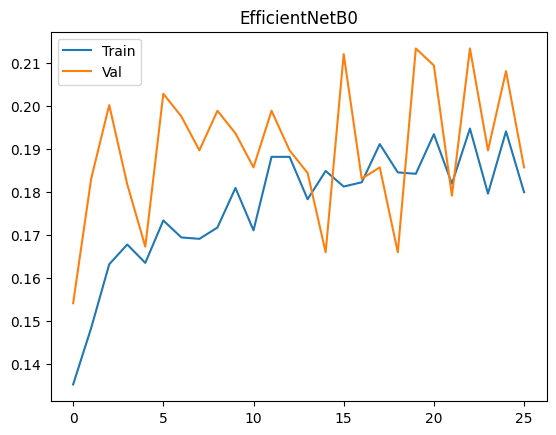

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
model = build_efficientnet(len(class_names))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('EfficientNetB0_best.h5', save_best_only=True)])
plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']); plt.title("EfficientNetB0"); plt.legend(['Train','Val']); plt.show()
evaluate_model(model, train_ds, "Train"); evaluate_model(model, val_ds, "Validation"); evaluate_model(model, test_ds, "Test")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2279 - loss: 3.4973

380/380 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.2280 - loss: 3.4960 - val_accuracy: 0.3913 - val_loss: 2.4422
Epoch 2/100
378/380 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3243 - loss: 2.4260

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3244 - loss: 2.4257 - val_accuracy: 0.3808 - val_loss: 2.0786
Epoch 3/100
379/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3568 - loss: 2.2257

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3568 - loss: 2.2256 - val_accuracy: 0.4124 - val_loss: 1.9446
Epoch 4/100
376/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3707 - loss: 2.1412

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3704 - loss: 2.1411 - val_accuracy: 0.4440 - val_loss: 1.8814
Epoch 5/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3614 - loss: 2.0793

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3614 - loss: 2.0793 - val_accuracy: 0.4704 - val_loss: 1.7067
Epoch 6/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3517 - loss: 2.0416 - val_accuracy: 0.4045 - val_loss: 1.8036
Epoch 7/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3679 - loss: 1.9807 - val_accuracy: 0.3966 - val_loss: 1.8388
Epoch 8/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3849 - loss: 1.9330 - val_accuracy: 0.4730 - val_loss: 1.7491
Epoch 9/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3753 - loss: 1.9603 - val_accuracy: 0.3992 - val_loss: 1.8548
Epoch 10/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3708 - loss: 1.9392 - val_accuracy: 0.4532 - val_loss: 1.7846
Epoch 11/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3515 - loss: 1.9737 - val_accuracy: 0.3966 - val_loss: 1.7387
Epoch 12/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3730 - loss: 1.9162 - val_accur

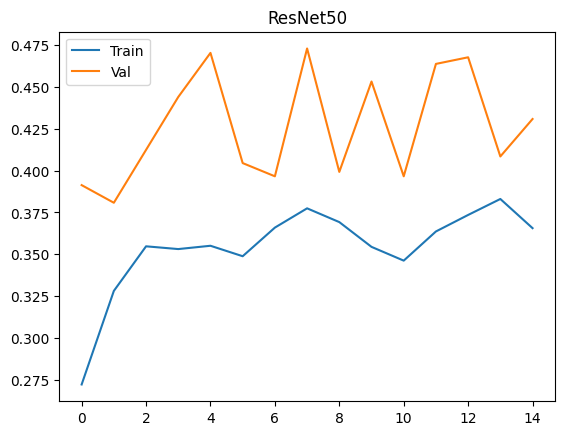

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━

In [ ]:
model = build_resnet50(len(class_names))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('ResNet50_best.h5', save_best_only=True)])
plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']); plt.title("ResNet50"); plt.legend(['Train','Val']); plt.show()
evaluate_model(model, train_ds, "Train"); evaluate_model(model, val_ds, "Validation"); evaluate_model(model, test_ds, "Test")

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2295 - loss: 3.2848

380/380 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.2296 - loss: 3.2836 - val_accuracy: 0.4005 - val_loss: 2.2724
Epoch 2/100
377/380 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2981 - loss: 2.4096

380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.2983 - loss: 2.4088 - val_accuracy: 0.4018 - val_loss: 1.9945
Epoch 3/100
377/380 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3203 - loss: 2.2140

380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.3205 - loss: 2.2136 - val_accuracy: 0.4572 - val_loss: 1.8303
Epoch 4/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3424 - loss: 2.1187 - val_accuracy: 0.4190 - val_loss: 1.8740
Epoch 5/100
378/380 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3513 - loss: 2.0715

380/380 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.3514 - loss: 2.0712 - val_accuracy: 0.4677 - val_loss: 1.7739
Epoch 6/100
379/380 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3619 - loss: 2.0148

380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.3619 - loss: 2.0148 - val_accuracy: 0.4611 - val_loss: 1.7700
Epoch 7/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3416 - loss: 2.0301 - val_accuracy: 0.3979 - val_loss: 1.8561
Epoch 8/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3566 - loss: 1.9694

380/380 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.3566 - loss: 1.9694 - val_accuracy: 0.4506 - val_loss: 1.7453
Epoch 9/100
377/380 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3650 - loss: 1.9424

380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.3650 - loss: 1.9423 - val_accuracy: 0.4638 - val_loss: 1.6665
Epoch 10/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3902 - loss: 1.9067 - val_accuracy: 0.4638 - val_loss: 1.7061
Epoch 11/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3609 - loss: 1.9281 - val_accuracy: 0.4387 - val_loss: 1.7541
Epoch 12/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3447 - loss: 1.9457 - val_accuracy: 0.4374 - val_loss: 1.7247
Epoch 13/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3628 - loss: 1.9305 - val_accuracy: 0.4269 - val_loss: 1.7579
Epoch 14/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3414 - loss: 1.9489 - val_accuracy: 0.4256 - val_loss: 1.7545
Epoch 15/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3625 - loss: 1.9447 - val_accuracy: 0.4928 - val_loss: 1.7060
Epoch 16/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3588 - loss: 1.9555 - val_a

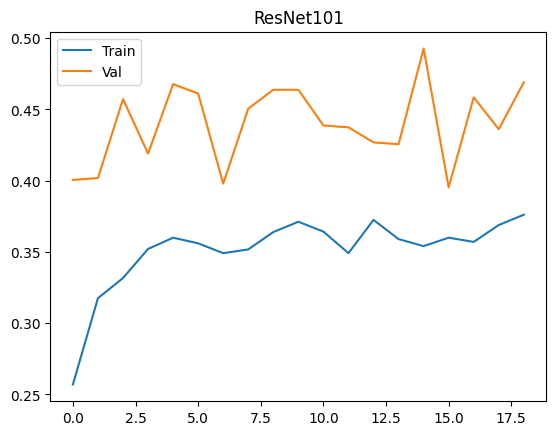

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━

In [ ]:
model = build_resnet101(len(class_names))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('ResNet101_best.h5', save_best_only=True)])
plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']); plt.title("ResNet101"); plt.legend(['Train','Val']); plt.show()
evaluate_model(model, train_ds, "Train"); evaluate_model(model, val_ds, "Validation"); evaluate_model(model, test_ds, "Test")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3599 - loss: 3.8172

380/380 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.3601 - loss: 3.8159 - val_accuracy: 0.6574 - val_loss: 2.4503
Epoch 2/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5507 - loss: 2.5402

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5507 - loss: 2.5399 - val_accuracy: 0.7233 - val_loss: 1.7521
Epoch 3/100
377/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6066 - loss: 2.0331

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6064 - loss: 2.0326 - val_accuracy: 0.7352 - val_loss: 1.5221
Epoch 4/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6271 - loss: 1.7513

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6271 - loss: 1.7513 - val_accuracy: 0.7655 - val_loss: 1.2347
Epoch 5/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6338 - loss: 1.5763 - val_accuracy: 0.7246 - val_loss: 1.2494
Epoch 6/100
376/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6164 - loss: 1.5381

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6165 - loss: 1.5380 - val_accuracy: 0.7273 - val_loss: 1.1606
Epoch 7/100
379/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6300 - loss: 1.4791

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6299 - loss: 1.4791 - val_accuracy: 0.7497 - val_loss: 1.1108
Epoch 8/100
378/380 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6139 - loss: 1.4638

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6140 - loss: 1.4636 - val_accuracy: 0.7708 - val_loss: 1.0386
Epoch 9/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6504 - loss: 1.3638 - val_accuracy: 0.7404 - val_loss: 1.0871
Epoch 10/100
378/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6249 - loss: 1.4091

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6250 - loss: 1.4090 - val_accuracy: 0.7747 - val_loss: 1.0312
Epoch 11/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6552 - loss: 1.3284 - val_accuracy: 0.7918 - val_loss: 1.0384
Epoch 12/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6471 - loss: 1.3793 - val_accuracy: 0.7681 - val_loss: 1.0424
Epoch 13/100
377/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6327 - loss: 1.3808

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6325 - loss: 1.3810 - val_accuracy: 0.7958 - val_loss: 1.0109
Epoch 14/100
379/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6464 - loss: 1.3301

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6463 - loss: 1.3303 - val_accuracy: 0.7708 - val_loss: 1.0010
Epoch 15/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6198 - loss: 1.4054 - val_accuracy: 0.7787 - val_loss: 1.0209
Epoch 16/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6563 - loss: 1.3136 - val_accuracy: 0.7655 - val_loss: 1.0100
Epoch 17/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6361 - loss: 1.3840 - val_accuracy: 0.7207 - val_loss: 1.0968
Epoch 18/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6397 - loss: 1.3761 - val_accuracy: 0.7681 - val_loss: 1.0078
Epoch 19/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6489 - loss: 1.3218 - val_accuracy: 0.7839 - val_loss: 1.0109
Epoch 20/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6447 - loss: 1.3503 - val_accuracy: 0.7681 - val_loss: 1.0170
Epoch 21/100
377/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6568 - loss: 1.3307

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6567 - loss: 1.3308 - val_accuracy: 0.7918 - val_loss: 0.9656
Epoch 22/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6650 - loss: 1.3012 - val_accuracy: 0.7299 - val_loss: 1.1077
Epoch 23/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6695 - loss: 1.3174 - val_accuracy: 0.7484 - val_loss: 1.0807
Epoch 24/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6466 - loss: 1.3564 - val_accuracy: 0.7747 - val_loss: 1.0046
Epoch 25/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6505 - loss: 1.3305 - val_accuracy: 0.7826 - val_loss: 1.0000
Epoch 26/100
377/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6714 - loss: 1.2979

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6712 - loss: 1.2984 - val_accuracy: 0.7997 - val_loss: 0.9602
Epoch 27/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6612 - loss: 1.2986 - val_accuracy: 0.7892 - val_loss: 0.9636
Epoch 28/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6552 - loss: 1.3329 - val_accuracy: 0.7549 - val_loss: 1.0511
Epoch 29/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6490 - loss: 1.3374 - val_accuracy: 0.7773 - val_loss: 1.0079
Epoch 30/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6542 - loss: 1.3222 - val_accuracy: 0.7760 - val_loss: 1.0208
Epoch 31/100
379/380 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6508 - loss: 1.3410

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6508 - loss: 1.3411 - val_accuracy: 0.8090 - val_loss: 0.9479
Epoch 32/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6443 - loss: 1.3689 - val_accuracy: 0.7444 - val_loss: 1.0397
Epoch 33/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6448 - loss: 1.3517 - val_accuracy: 0.7813 - val_loss: 1.0255
Epoch 34/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6464 - loss: 1.3403 - val_accuracy: 0.7760 - val_loss: 1.0162
Epoch 35/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6559 - loss: 1.2831 - val_accuracy: 0.7747 - val_loss: 1.0178
Epoch 36/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6501 - loss: 1.3644 - val_accuracy: 0.7839 - val_loss: 0.9825
Epoch 37/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6456 - loss: 1.3419 - val_accuracy: 0.7681 - val_loss: 1.0234
Epoch 38/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6544 - loss: 1.3277 - val_a

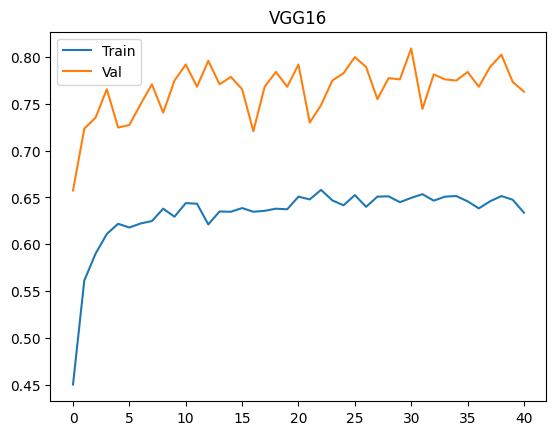

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

In [ ]:
model = build_vgg16(len(class_names))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('VGG16_best.h5', save_best_only=True)])
plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']); plt.title("VGG16"); plt.legend(['Train','Val']); plt.show()
evaluate_model(model, train_ds, "Train"); evaluate_model(model, val_ds, "Validation"); evaluate_model(model, test_ds, "Test")

Clearly VGG16 model outperforms others.

REFERENCES:
1. https://www.tensorflow.org/api_docs/python/tf/keras
2. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
3. https://keras.io/api/applications/
4. https://keras.io/guides/transfer_learning/